In [3]:
# Functional API 모델 사용 추천한것에서 early_stopping 제외 결정계수 -29 모델성능 없다고 봄

결측값이 없습니다.
Epoch 1/1000


C:\Users\user\AppData\Local\Temp\ipykernel_12664\76141959.py:11: DtypeWarning: Columns (4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./encoded_data.csv')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1813.9540 - mean_absolute_error: 31.8324 - val_loss: 151.8932 - val_mean_absolute_error: 10.8998
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 

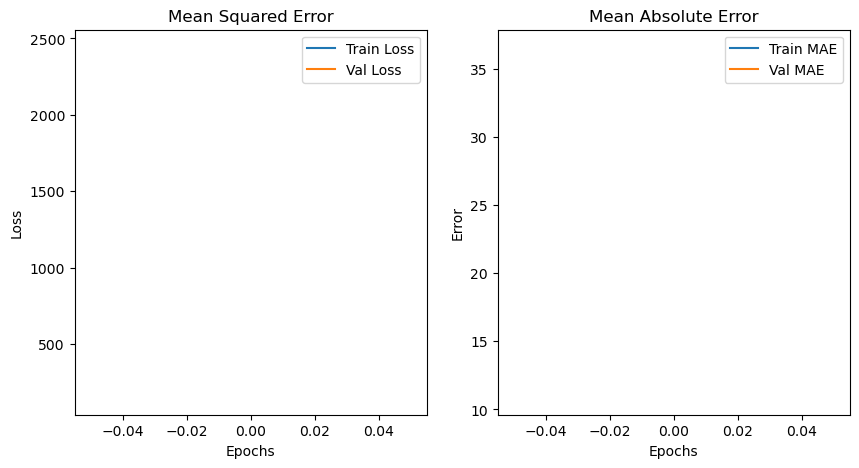

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: nan - mean_absolute_error: nan
Test Loss: nan
Test MAE: nan
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: nan - mean_absolute_error: nan
Validation Loss: nan
Validation MAE: nan
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
예측값에 NaN이 존재합니다. NaN 값을 0으로 대체합니다.
R2 Score: -29.188829077555845


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import shap

# 데이터 로드
df = pd.read_csv('./encoded_data.csv')

# change_date 열을 제외한 나머지 열 선택
X = df.drop(columns=['change_date'])
y = df['change_date'].values  # 예측값

# 결측값 처리 (예: 평균값으로 대체)
X.replace('-', np.nan, inplace=True)
X = X.astype(np.float32)
X.fillna(X.mean(), inplace=True)

y = y.astype(np.float32)

# NaN 값이 있는지 확인
if np.any(np.isnan(X)) or np.any(np.isnan(y)):
    print("결측값이 존재합니다.")
else:
    print("결측값이 없습니다.")

# train/test 데이터셋 나누기 (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# train 데이터셋의 일부를 다시 train(sub)/val 데이터셋으로 나누기 (80% sub(train), 20% val)
X_sub, X_val, y_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_sub = scaler.transform(X_sub)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Functional API를 사용하여 모델 생성
inputs = tf.keras.Input(shape=(X.shape[1],))
x = tf.keras.layers.Dense(128, activation='relu')(inputs)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# 회귀를 위한 손실 함수(mean squared error)와 메트릭스(mean absolute error) 사용하여 모델 컴파일
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=['mean_absolute_error'])

# 조기 종료 콜백 추가 (과적합 방지)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_sub, y_sub, validation_data=(X_val, y_val), epochs=1000, batch_size=1000) #(, callbacks=[early_stopping])

# 학습 결과 시각화 (학습 곡선 시각화)
plt.figure(figsize=(10, 5))

# subplot 1: Mean Squared Error 손실 함수의 변화
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# subplot 2: Mean Absolute Error 매트릭스의 변화
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()

plt.show()

# 모델 평가 - 테스트 데이터셋 사용
loss_test, mae_test = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss_test}')
print(f'Test MAE: {mae_test}')

# 모델 평가 - 검증 데이터셋 사용
loss_val, mae_val = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss_val}')
print(f'Validation MAE: {mae_val}')

# 예측값 생성
predictions = model.predict(X_val)

# NaN 값이 있는지 확인 및 처리
if np.any(np.isnan(predictions)):
    print("예측값에 NaN이 존재합니다. NaN 값을 0으로 대체합니다.")
    predictions = np.nan_to_num(predictions)

# 결정계수 계산
r2 = r2_score(y_val, predictions)
print(f'R2 Score: {r2}')


In [ ]:
# 잔차 플롯
# 잔차 계산
residuals = y_val - predictions.flatten()

plt.figure(figsize=(10, 5))
plt.scatter(predictions, residuals, alpha=0.3)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.hlines(0, min(predictions), max(predictions), colors='red')
plt.show()

# SHAP 값 시각화
import shap

# SHAP 값을 계산하기 위해 샘플 데이터 준비
explainer = shap.DeepExplainer(model, X_sub)
shap_values = explainer.shap_values(X_val)

# SHAP 값을 시각화
shap.summary_plot(shap_values, X_val, feature_names=X.columns.tolist())